
# Investigating the effect of patient characteristics and of wait time between appointment scheduling and attendance on patient hospital appointment attendance in Vitoria, Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This analysis explores a Kaggle dataset of medical appointments in Vitoria, Brazil. It includes 110,527 entries of hospital appointments made for 38,687 men and 71,840 women, living across 81 neighborhoods in and around Vitoria and ranging in age from less than a year old to 115. For each appointment, the dataset also includes information when each appointment was scheduled, the days and times each appointment occured, key patient characteristics (including whether they are enrolled in the Brazilian welfare program Bolsa Familia or have hypertension, diabetes, alcoholism, or a handicap) whether a SMS reminder was sent to the pateint, and whether the patient came to the appointment or "no-showed." In this report, I explore the following questions: 
    1) Does receiving a scholarship or SMS reminder, or having hypertension, diabetes, alcoholism, or a handicap predict no-
    show behavior?
    2) Does wait time between appointment scheduling and attendance predict no-show behavior? 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> First, I added the dataset to the same folder as this notebook so I could upload the dataset using the following code:

In [73]:
df = pd.read_csv('noshowappointments.csv')

> Then I used the shape method to see how many rows and columns the dataset contained.

In [74]:
df.shape

(110527, 14)

>I then calcuated the number of women and men in the dataset, as well as the age distribution, to be able to better understand the population.

In [75]:
df_women = df[df['Gender'] == 'F']
df_women.count()

PatientId         71840
AppointmentID     71840
Gender            71840
ScheduledDay      71840
AppointmentDay    71840
Age               71840
Neighbourhood     71840
Scholarship       71840
Hipertension      71840
Diabetes          71840
Alcoholism        71840
Handcap           71840
SMS_received      71840
No-show           71840
dtype: int64

In [76]:
df_men = df[df['Gender'] == 'M']
df_men.count()

PatientId         38687
AppointmentID     38687
Gender            38687
ScheduledDay      38687
AppointmentDay    38687
Age               38687
Neighbourhood     38687
Scholarship       38687
Hipertension      38687
Diabetes          38687
Alcoholism        38687
Handcap           38687
SMS_received      38687
No-show           38687
dtype: int64

In [77]:
df['Age'].describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

> Then I used the info method to see the column names, the different datatypes used for each column, and to see if there were any missing values. 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


>I first noticed a typo in Hypertension and Handicap ("Hipertension" in the dataset and "Handicap") that needed to be corrected during cleaning. I also thought that the dash in "No-show" could be problematic since the dash is a mathematical operation in python, so I decided to change it to "No_show" during cleaning.

>I then noticed that ScheduledDay and AppointmentDay were objects, which upon further investigation, turned out to be strings. I noted these columns needed to be converted to datetime objects when cleaning. 

In [79]:
type(df['ScheduledDay'][0])

str

In [80]:
type(df['AppointmentDay'][0])

str

>I also thought that it would be helpful to convert the No-show data from an object (Yes or No) to an integer (1 or 0) to be consistent with the other ways Yes/No data is handled in the dataset, and to allow for easier computation.

>Finally, I observed there were no missing values.

> I then used the nunique method to investigate how many unique patients there are in the dataset. The total number of patient IDs was smaller than the appointment ID, which made me want to check for duplicates using the duplicated method. 

In [81]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [82]:
sum(df.duplicated())

0

>Upon checking, I found that there were no duplicated rows, which suggests that some patients are making multiple appointments. I Invesigated this further using the groupby method to count the number of distinct appointments for each patient ID. The median patient makes one appointment, but the 75th percentile make two, and the max number of appointments made was 88! 

In [83]:
num_appointments_per_patient = df.groupby('PatientId').count().AppointmentID
num_appointments_per_patient.describe()

count    62299.000000
mean         1.774138
std          1.770324
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: AppointmentID, dtype: float64

### Data Cleaning

>First, I corrected the typos previously identified in the column names.

In [84]:
df.rename(columns={'Hipertension': 'Hypertension', 'Handcap' : 'Handicap', 'No-show' : 'No_show'}, inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


>Then I changed the No_show column from an object datatype with a "Yes" or "No" to an integer datatye with 1 or 0.

In [85]:
df.replace(('Yes', 'No'),(1,0), inplace=True)
df['No_show'] = df['No_show'].astype(int)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


>I then converted the datatypes for the ScheduledDay and AppointmentDay from objects to datetime objects.

In [86]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
No_show           110527 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(9), object(2)
memory usage: 11.8+ MB


>Upon looking at the ScheduledDay and Appointment Day columns, I found that there were cases where the AppointmentDay (the day an appointment was made) is later than the ScheduledDay (the day a patient is meant to attend the appointment).

In [88]:
df.iloc[:, 3:5].head(10)

,ScheduledDay,AppointmentDay
0,2016-04-29 18:38:08,2016-04-29
1,2016-04-29 16:08:27,2016-04-29
2,2016-04-29 16:19:04,2016-04-29
3,2016-04-29 17:29:31,2016-04-29
4,2016-04-29 16:07:23,2016-04-29
5,2016-04-27 08:36:51,2016-04-29
6,2016-04-27 15:05:12,2016-04-29
7,2016-04-27 15:39:58,2016-04-29
8,2016-04-29 08:02:16,2016-04-29
9,2016-04-27 12:48:25,2016-04-29


>To corect for this error, I added 23 hours and 59 seconds to each appointment day value.

In [89]:
df['AppointmentDay'] = df['AppointmentDay'] + pd.Timedelta('1d') - pd.Timedelta('1s')

>Lastly, since I am not making use of the neighbourhood variable in this analysis, I decided to drop it from the dataset.

In [90]:
df.drop(['Neighbourhood'], axis=1, inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis


### What characteristics are associated with not attending an appointment?

>To evaluate what characteristics are associated with not attending an appointment (or "no shows"), I first needed to count how many no-shows there were in total.

In [91]:
df_no_show = df[df['No_show'] == 1]

In [92]:
no_show_totals = df_no_show['No_show'].count()
print(no_show_totals)

22319


>Once I had the total number of no-shows, I caluclated the number of women and men who no-showed, and divided that by the total population of women and men in the dataset.

In [93]:
no_show_men = df_no_show[df_no_show['Gender'] == 'M']
percent_of_men_no_show = no_show_men.count() / df_men.count()

In [94]:
no_show_women = df_no_show[df_no_show['Gender'] == 'F']
percent_of_women_no_show = no_show_women.count() / df_women.count()

>I then subtracted the percent of men that no-showed from the percent of women that no-showed and found less than a percentage point difference.

In [95]:
percent_of_women_no_show - percent_of_men_no_show

Age               0.003466
Alcoholism        0.003466
AppointmentDay    0.003466
AppointmentID     0.003466
Diabetes          0.003466
Gender            0.003466
Handcap                NaN
Handicap               NaN
Hipertension           NaN
Hypertension           NaN
Neighbourhood          NaN
No-show                NaN
No_show                NaN
PatientId         0.003466
SMS_received      0.003466
ScheduledDay      0.003466
Scholarship       0.003466
dtype: float64

>I then counted how many no-shows were associated with patients that received a scholarship or SMS reminder, or had hypertension, diabetes, alcoholism, or a handicap.

In [96]:
df_no_show_total_summary = df_no_show.iloc[:, 7:13].sum()
print(df_no_show_total_summary)

Hypertension     3772
Diabetes         1430
Alcoholism        677
Handicap          453
SMS_received     9784
No_show         22319
dtype: int64


>Then for each characteristic, I calculated the proportion of all no-shows in which a patient had that characeristic.

In [97]:
df_no_show_total_proportion = df_no_show_total_summary / no_show_totals
print(df_no_show_total_proportion)

Hypertension    0.169004
Diabetes        0.064071
Alcoholism      0.030333
Handicap        0.020297
SMS_received    0.438371
No_show         1.000000
dtype: float64


>I then created a list to be able to use the percentages in the y-axis of a bar chart.

In [98]:
no_show_percentages = [16.9, 6.4, 3.0, 2.0, 43.8, 11.6]
print(no_show_percentages)

[16.9, 6.4, 3.0, 2.0, 43.8, 11.6]


>I then created a bar chart to visually compare the characteristics and evaluate whether any one characteristic was associated with no shows.

Text(0.5,1,'Percent of No-Shows with Key Characteristics')

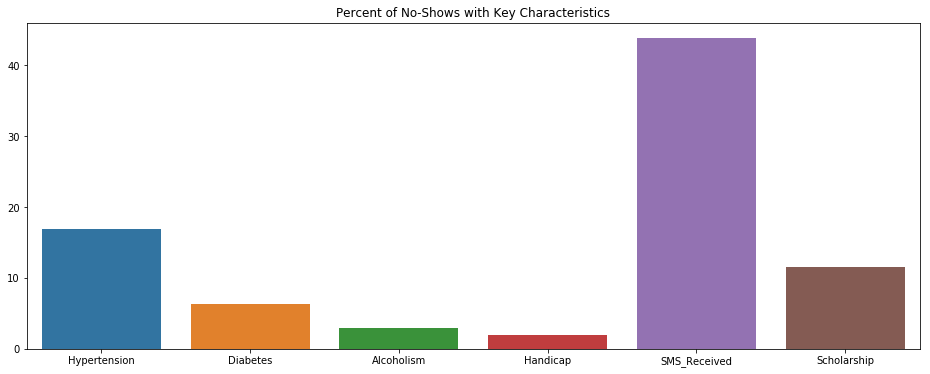

In [99]:
plt.figure(figsize=(16,6))
sns.barplot(x=['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Received', 'Scholarship'], y=no_show_percentages).set_title("Percent of No-Shows with Key Characteristics")

>In order to interpret this information, I decided to compare the prevalence of these characteristics in patients that did attend their appointments by following the same steps.

In [100]:
df_attended = df[df['No_show'] == 0]

In [101]:
df_attended_totals = df_attended.count()
df_attended_totals.head()

PatientId         88208
AppointmentID     88208
Gender            88208
ScheduledDay      88208
AppointmentDay    88208
dtype: int64

In [102]:
df_attended_total_summary = df_attended.iloc[:, 7:13].sum()
print(df_attended_total_summary)

Hypertension    18029
Diabetes         6513
Alcoholism       2683
Handicap         2006
SMS_received    25698
No_show             0
dtype: int64


In [103]:
df_attended_total_proportion = df_attended_total_summary / df_attended_totals
print(df_attended_total_proportion)

Age                    NaN
Alcoholism        0.030417
AppointmentDay         NaN
AppointmentID          NaN
Diabetes          0.073837
Gender                 NaN
Handicap          0.022742
Hypertension      0.204392
No_show           0.000000
PatientId              NaN
SMS_received      0.291334
ScheduledDay           NaN
Scholarship            NaN
dtype: float64


In [104]:
attended_percentages = [20.4, 7.4, 3.0, 2.3, 29.1, 9.3]

Text(0.5,1,'Percent of Patients Attended with Key Characteristics')

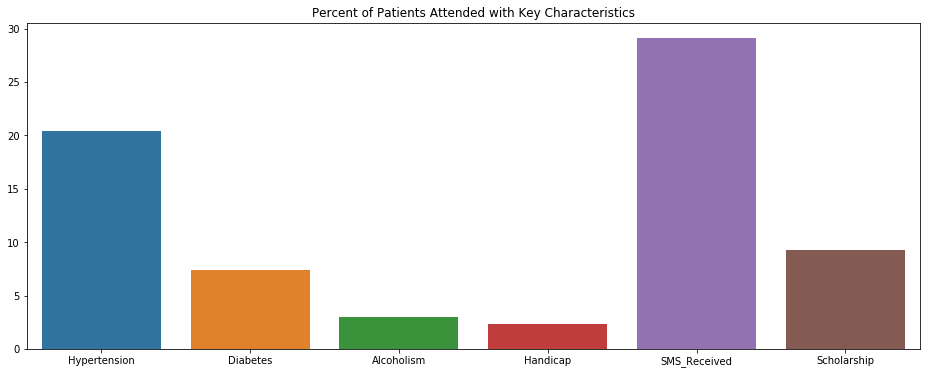

In [105]:
plt.figure(figsize=(16,6))
sns.barplot(x=['Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Received', 'Scholarship'], y=attended_percentages).set_title('Percent of Patients Attended with Key Characteristics')

>I found that there was very little difference in hypertension, diabetes, alcoholism, handicap, or scholarship reception between the patients that no-showed and the patients who attended. The biggest difference was in SMS reception: 43.8% of patients that no-showed received an SMS, while 29.1% of patients who attended their appointments received an SMS.

>The last characteristic I looked at was age. To understand how age impacted no-shows, I first created 3 age groups: young, middle age, and old. I then asked, "How many patients are in each age group?"

In [106]:
df_25th_percentile = df['Age'].quantile(.25)
df_25th_percentile

18.0

In [107]:
df_young = df.query('Age <= 18')
df_young['PatientId'].count()

28867

In [108]:
df_50th_percentile = df['Age'].quantile(.50)
df_50th_percentile

37.0

In [109]:
df_middle_age = df.query('18 < Age <= 37')
df_middle_age['PatientId'].count()

27250

In [110]:
df_75th_percentile = df['Age'].quantile(.75)
df_75th_percentile

55.0

In [111]:
df_old = df.query('Age > 37')
df_old['PatientId'].count()

54410

>I then created a bar chart to visually compare the size of the young, middle age, and old age groups.

In [112]:
df_group_sizes = [28867, 27250, 54410]

Text(0.5,1,'Number of Patients Per Age Group')

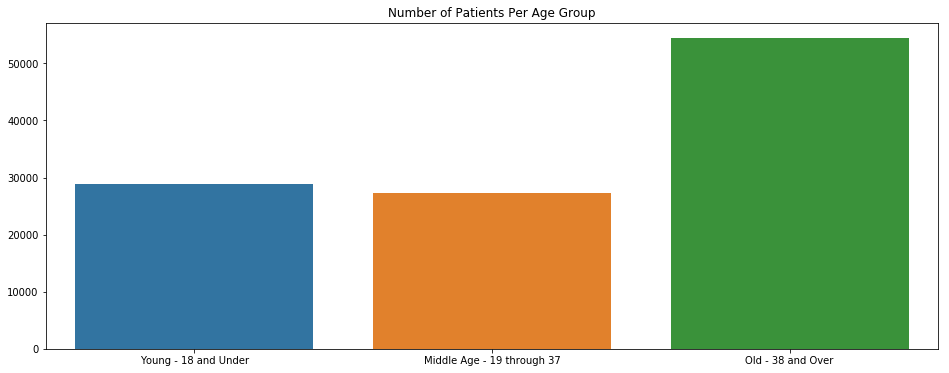

In [113]:
plt.figure(figsize=(16,6))
sns.barplot(x=['Young - 18 and Under', 'Middle Age - 19 through 37', 'Old - 38 and Over'], y=df_group_sizes).set_title('Number of Patients Per Age Group')

>I then counted the no-shows in each age group and calculated the proportion of the age group's popualation that were no shows.

In [114]:
df_young.groupby('No_show').count()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
No_show,,,,,,,,,,,,
0,22520,22520,22520,22520,22520,22520,22520,22520,22520,22520,22520,22520
1,6347,6347,6347,6347,6347,6347,6347,6347,6347,6347,6347,6347


In [115]:
df_young_proportion_no_show = 6347 / 28867
df_young_proportion_no_show

0.2198704402951467

In [116]:
df_middle_age.groupby('No_show').count()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
No_show,,,,,,,,,,,,
0,20836,20836,20836,20836,20836,20836,20836,20836,20836,20836,20836,20836
1,6414,6414,6414,6414,6414,6414,6414,6414,6414,6414,6414,6414


In [117]:
df_middle_age_proportion_no_show = 6414 / 27250
df_middle_age_proportion_no_show

0.23537614678899083

In [118]:
df_old.groupby('No_show').count()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received
No_show,,,,,,,,,,,,
0,44852,44852,44852,44852,44852,44852,44852,44852,44852,44852,44852,44852
1,9558,9558,9558,9558,9558,9558,9558,9558,9558,9558,9558,9558


In [119]:
df_old_proportion_no_show = 9558 / 54410
df_old_proportion_no_show

0.17566623782392943

>Afeter visualizing the proportions of each age group that no-show in a graph, I observed that there is little difference in no-shows among the different age groups.

Text(0.5,1,'Percent of No-Shows Among Age Groups')

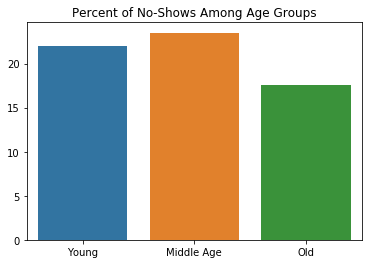

In [120]:
plt.figure()
sns.barplot(x=['Young', 'Middle Age', 'Old'], y=[22.0, 23.5, 17.6]).set_title('Percent of No-Shows Among Age Groups')

### How does waiting time between appointment scheduling and attendance impact no-show behavior?

>I created a new variable "AwaitingTime" to be the difference between the AppointmentDay and the ScheduledDay values.

In [121]:
df['AwaitingTime'] = df['AppointmentDay'] - df['ScheduledDay']
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AwaitingTime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,0,1,0,0,0,0,0,05:21:51
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,0,0,0,0,0,0,0,07:51:32
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,0,0,0,0,0,0,0,07:40:55
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,0,0,0,0,0,0,0,06:30:28
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,0,1,1,0,0,0,0,07:52:36


>Then I created a variable "AwaitingDays" by extracting the days from AwaitingTime.

In [122]:
df['AwaitingDays'] = df['AwaitingTime'].dt.days

In [123]:
df_AwaitingDays = df['AwaitingTime'].dt.days

>Once I had the column AwaitingDays, I could analyze the relationship between no-shows and the number of days a patient waited between scheduling and attending the appointment. Looking at the mean number of days waiting (AwaitingDays) for patients who came to their appointment (and therefore have a 0 in the no-show column) and the mean for patients who did not show up for their appointment (and therefore have a 1 in the no-show column) revealed an intriguing difference.

In [124]:
df.groupby('No_show').mean().AwaitingDays

No_show
0     8.754659
1    15.831489
Name: AwaitingDays, dtype: float64

>I decided to add AwaitingTime as a column to the df_no_show dataframe and create a histogram to see the distribution of days waiting among patients that no-showed.

In [125]:
df_no_show['AwaitingTime'] = df['AppointmentDay'] - df['ScheduledDay']
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AwaitingTime,AwaitingDays
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 23:59:59,62,0,1,0,0,0,0,0,05:21:51,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 23:59:59,56,0,0,0,0,0,0,0,07:51:32,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 23:59:59,62,0,0,0,0,0,0,0,07:40:55,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 23:59:59,8,0,0,0,0,0,0,0,06:30:28,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 23:59:59,56,0,1,1,0,0,0,0,07:52:36,0


In [126]:
df_no_show['AwaitingDays'] = df['AwaitingTime'].dt.days

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Number of Patients')

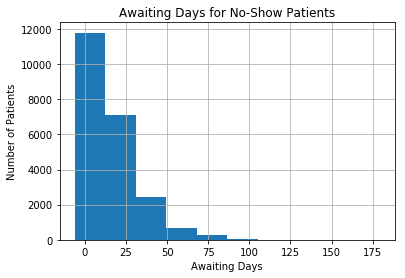

In [127]:
df_no_show['AwaitingDays'].hist()
plt.title('Awaiting Days for No-Show Patients')
plt.xlabel('Awaiting Days')
plt.ylabel('Number of Patients')

>I then compared the no-show distribution to the histogram showing the distribution of days waiting for patients that did show up for their appointments.

In [128]:
df_showed_up = df[df['No_show'] == 0]


Text(0,0.5,'Number of Patients')

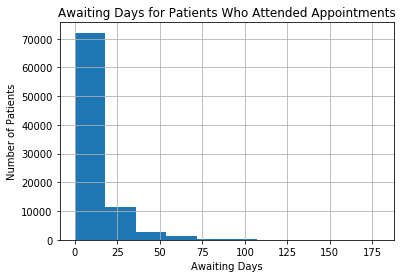

In [129]:
df_showed_up['AwaitingDays'].hist()
plt.title('Awaiting Days for Patients Who Attended Appointments')
plt.xlabel('Awaiting Days')
plt.ylabel('Number of Patients')

>Comparing the 2 histograms, the distribution of AwaitingDays was skewed to the right for patients who no-showed.

<a id='conclusions'></a>
## Conclusions

> In summary, I found less than a percentage point of difference between men who were "no-shows" and women who were "no-shows." I also found little difference in hypertension, diabetes, alcoholism, handicap, or scholarship reception between the patients that no-showed and the patients who attended. There was also little difference in the percent of no-shows among the three age groups I created. I did find that 43.8% of patients that no-showed received an SMS, while 29.1% of patients who attended their appointments received an SMS. I also found that patients who no-show have approximately 7 days more of wait time between scheduling and attending their appointment than patients who do attend. 

## Limitations
>With respect to the analysis I did on age groups, my analysis is limited because I only created 3 age groups. The relationship between age and no-show behavior could be better understood by creating more age groups with smaller age ranges. Additionally, further analysis should be done to understand why there might be a 14.7 percentage point difference in no-show behavior between patients who received SMS messages and those that did not. Finally, more analysis needs to be done to understand the nature of the relationship between the higher average wait time between scheduling and appointment for no-shows. 


In [130]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0